# **Homework 2: Image segmentation without user input**

## Overview
This homework has two parts.

The first part of this homework is to implement [Grad-CAM](https://arxiv.org/pdf/1610.02391) – a method for producing saliency maps (heatmaps of regions that are most relevant to a model) that uses both activations and gradients of the feature maps of a convolutional layer. Feature maps of deeper convolutional layers represent more high-level features, while preserving rough spatial structure, which makes them a good candidate for explaining a model's output.

The second part of this homework is to use SAM for image segmentation without user input.
SAM [(Segment Anything Model v1)](https://arxiv.org/pdf/2304.02643) is a popular family of open-weight models for image segmentation (based on the vision transformer ViT and CLIP).
The model takes as input an image to be segmented and additionaly bounding boxes, point coordinates etc. clarifying the object of interest to be segmented. It can output many proposed segmentations of many objects on one image. Your task will be to find appropriate point coordinates automatically, so that SAM can be used with just an image input to segment particular objects.

---

## Dataset

You will use a small custom dataset based on [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10), but containing images with one of five objects (circle, square, diamond, triangle, star), with ground-truth segmentations of that object.

---

## GradCAM task

For the first task:
* Read the original [Grad-CAM](https://arxiv.org/pdf/1610.02391) paper.
* Implement it, without using non-standard packages (the only imports allowed are built-ins, torch, torchvision, numpy, scipy, and helpers like cv2, PIL, tqdm, matplotlib).
* The result should be a class named `GradCAM` with methods:
    * `def __init__(model: nn.Module, target_layers=Iterable[nn.Module])`
    * `def __call__(self, image: Tensor, targets: Iterable[int] | None = None) -> np.ndarray` where
        * `image` is an input to `model` (a normalized batch of shape `B,C,H,W`).
        * `targets` is an iterable of target classes that we want to segment; if None is given, use the top class predicted by the model.
        * The result is a numpy array of shape (B, H, W) containing the GradCam heatmap, with `min..max` values rescaled to `0..1` (independently for each image in the batch and each `target_layers`). If more than one `target_layers` was given, return the average of the resulting heatmaps.      
    * Feel free to add optional/default arguments and additional methods.
* Check your implementation by running the code under the `GradCAM results` header.

Tip: you may find it particularly useful to use: [nn.Module.register_full_backward_hook](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook).


## Segmentation task

For the second part, SAM is given as a black-box. You must design a pipeline that takes only an image and outputs a segmentation of the circle/square/diamond/triangle/star shape. The input to SAM should be the image and coordinates of point(s) that are likely to be inside ("foreground") or likely to be outside ("background") of the shape. **The coordinates must be the output of the previous step of the pipeline. They cannot be provided directly by user.**

* Think of a way to find appropriate points. Try two different approaches:
    1. at least one foreground point, without background points.
    2. at least one foreground point and at least one background point.
* Implement both approches as subclasses of `BasicSamPipeline`, overriding the `__call__` method (preserving the signature).
* Evaluate your generated point(s) and report the following metrics:
    * *hit rate*: how often they fall inside the ground-truth mask;
    * *distance*: distance from the center of mass of the ground-truth mask
        (the average coordinate of True pixels in the mask).
* Evaluate your overall pipeline and report the following metric:
    * *Intersection over Union (IoU)* of the predicted and ground-truth masks, averaged over all images in the dataset.


**Important**: This task is not about finding the pipeline with best hyperparameters; we expect an IoU of at least `65%`, but achieving results higher than that will not affect the grade for the assignment.

**Important**: Do not train or fine-tune your own models, only use the ones provided (the classifier and SAM).

---

## Deliverables

On [Moodle](https://moodle.mimuw.edu.pl/mod/assign/view.php?id=159965), submit a .zip archive with:

1. **Notebook** (`.ipynb`):
    * It should contain:
        * The GradCAM implementation.
        * The two `BasicSamPipeline` subclasses.
        * Evaluations with computations of all reported metrics.
    * It should be possible to execute the whole notebook start-to-end without human intervention.
    * Such an execution should take less than 30 minutes on a Colab GPU.
    * Do not modify (but *do* execute) cells under headers marked as `[do not modify]`. If you wish to extend them (e.g. to check more GradCAM results), you may do so **under a new header**.

2. **Report (1-2 pages, PDF)** including:
   * An examplary visualization of the output of the Grad-CAM
   * A concise description of each approach for the SAM pipelines (1-3 sentences each).
   * A presentation of all metrics.
   * Discussion (up to 5 sentences) on potential areas for improvements.

3. **README.md**:
   * Link to Colab version of the notebook for fast replication.



## Grading

1. Implementation correctness of Grad-CAM:  30%
2. Implementation correctness of the multistage pipeline and evaluations: 50%
3. Report & analysis: 20%

Please take care of readability, clear structure in particular (headers in notebooks, modular code).
This will be considered within each grading component.



# 0. Preliminaries

## Imports

In [1]:
# !pip install torch torchvision matplotlib opencv-python-headless numpy segment-anything tqdm

In [2]:
import os
import random
from collections.abc import Callable, Iterable
from pathlib import Path
from typing import Any, Final, Literal, TypedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.ndimage
import torch
import torch.nn.functional as F
import torchvision.models
from torch import Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from tqdm import tqdm

from typing import TypeVar, Generic

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

## Dataset [do not modify]

CIFAR-10 download takes 170 MiB.

In [4]:
# %%bash --no-raise-error
# mkdir -p data/
# wget -nc -q -O data/synthetic_shapes.zip https://www.mimuw.edu.pl/~mwrochna/upload/synthetic_shapes.zip
# unzip -d data/ data/synthetic_shapes.zip &> /dev/null

In [5]:
T = TypeVar("T")

class SyntheticData(Dataset, Generic[T]):
    """A small synthetic segmentation dataset.

    It is a sequence dataset of 5000 tuples (image, class, mask), where:
    - image: before transformation, an RGB PIL Image.
    - class: int 0..4, the label index.
    - mask:  numpy array of dtype=bool, shape (H, W), same size as image.
    """

    CLASSES: Final[tuple[str, ...]] = ("circle", "square", "triangle", "star", "diamond")

    def __init__(
        self,
        path: Path,
        split: Literal["train", "val", "test"],
        transform: Callable[[PIL.Image.Image], T],
    ) -> None:
        self.path = path
        self.transform = transform
        self.split = split

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.CLASSES)}

        images = sorted((self.path / "images" / self.split).glob("*.png"))
        masks = sorted((self.path / "masks" / self.split).glob("*.png"))
        labels = sorted((self.path / "labels" / self.split).glob("*.txt"))

        assert images, f"No images found in {self.path / 'images' / self.split}"
        assert len(images) == len(masks) == len(labels), (
            "Number of images, masks, and labels must be the same"
        )
        assert [p.stem for p in images] == [p.stem for p in masks] == [p.stem for p in labels], (
            "Image/mask/label filename mismatch."
        )
        self.image_names = [p.stem for p in images]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx: int) -> tuple[T, int, np.ndarray]:
        name = self.image_names[idx]
        img_path = self.path / "images" / self.split / f"{name}.png"
        mask_path = self.path / "masks" / self.split / f"{name}.png"
        label_path = self.path / "labels" / self.split / f"{name}.txt"

        img = PIL.Image.open(img_path).convert("RGB")
        mask = np.array(PIL.Image.open(mask_path), dtype=bool)
        label = self.class_to_idx[label_path.read_text().strip()]

        img_transformed: T = self.transform(img)

        return img_transformed, label, mask
    
def show_image_row(
    image_dict: dict[str, PIL.Image.Image | np.ndarray | Tensor], size: float = 3.0
) -> None:
    n = len(image_dict)
    _, axs = plt.subplots(1, n, figsize=(size * n, size), constrained_layout=True, squeeze=True)
    if n == 1:
        axs = [axs]
    for ax, (title, img) in zip(axs, image_dict.items(), strict=True):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()


train dataset size: 3500
val dataset size: 1000
test dataset size: 500


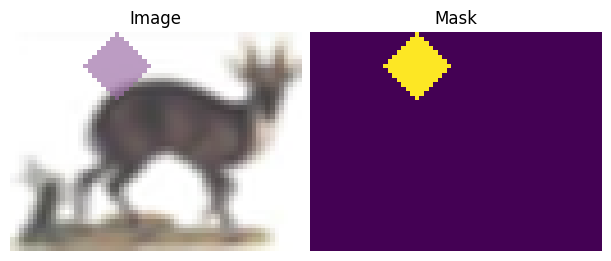

Label: 4 (diamond)


In [6]:
dataset_path = Path("./data/synthetic_shapes")


def example_from_dataset(idx: int = 3):
    for split in ("train", "val", "test"):
        dataset = SyntheticData(dataset_path, split=split, transform=lambda x: x)
        print(f"{split} dataset size: {len(dataset)}")

    img, label, mask = dataset[idx]
    show_image_row({"Image": img, "Mask": mask})
    print(f"Label: {label} ({SyntheticData.CLASSES[label]})")


example_from_dataset()

## Training a classifier [do not modify]

In [7]:
def train(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5,
    **optimizer_kwargs: Any,
) -> None:
    print(f"🚀 Training CNN for {epochs} epochs...")
    optimizer = optim.AdamW(model.parameters(), **optimizer_kwargs)

    for epoch in range(epochs):
        _train_epoch(model, train_loader, optimizer, desc=f"Epoch {epoch + 1}/{epochs} training  ")
        val_metrics = evaluate(model, val_loader, desc=f"Epoch {epoch + 1}/{epochs} validation")
        print(
            f"Epoch {epoch + 1}/{epochs} — "
            + f"val loss: {val_metrics['loss']:.3f}, val acc: {val_metrics['accuracy']:.1%}"
        )

    test_metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print(
        "✅ Model training complete: "
        + f"Test loss: {test_metrics['loss']:.3f}, test acc: {test_metrics['accuracy']:.1%}"
    )


def _train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    desc: str,
) -> dict[str, float]:
    model.train()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc=desc)
    for imgs, labels, _ in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.shape[0]
        total_correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(
            train_loss=f"{total_loss / (total_samples / labels.shape[0]):.3f}",
            train_acc=f"{total_correct / total_samples:.1%}",
        )

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


def evaluate(
    model: nn.Module, dataloader: torch.utils.data.DataLoader, desc: str
) -> dict[str, float]:
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for imgs, labels, _mask in tqdm(dataloader, desc=desc):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total_samples += labels.shape[0]
            total_correct += (predicted == labels).sum().item()

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


class DataloaderArgs(TypedDict, total=False):
    batch_size: int
    shuffle: bool
    num_workers: int
    pin_memory: bool

In [8]:
device = torch.accelerator.current_accelerator(check_available=True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
inverse_transform = v2.Compose(
    [
        v2.Normalize(
            [-m / s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD, strict=True)],
            [1 / s for s in IMAGENET_STD],
        ),
        v2.ToPILImage(),
    ]
)

train_dataset = SyntheticData(dataset_path, transform=transform, split="train")
val_dataset = SyntheticData(dataset_path, transform=transform, split="val")
test_dataset = SyntheticData(dataset_path, transform=transform, split="test")

train_kwargs: DataloaderArgs = {
    "batch_size": 128,
    "num_workers": 2,
    "shuffle": True,
    "pin_memory": use_accel,
}
val_kwargs: DataloaderArgs = {"batch_size": 500, "num_workers": 2, "pin_memory": use_accel}
test_kwargs: DataloaderArgs = val_kwargs

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(val_dataset, **val_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print("✅ DataLoaders created for train, validation, and test sets.")

Train dataset size: 3500
Validation dataset size: 1000
Test dataset size: 500
✅ DataLoaders created for train, validation, and test sets.


In [10]:
checkpoint_path = Path("./model_checkpoint.pth")

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(SyntheticData.CLASSES))
model = model.to(device)

if not checkpoint_path.exists():
    train(model, train_loader, val_loader, test_loader, epochs=5, lr=2e-3, weight_decay=0.05)
    torch.save(model.state_dict(), checkpoint_path)
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print()
    print(
        "✅ Model loaded from checkpoint: "
        + f"Test loss: {metrics['loss']:.3f}, test acc: {metrics['accuracy']:.1%}"
    )

Test Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


✅ Model loaded from checkpoint: Test loss: 0.442, test acc: 87.4%


# 1. GradCAM

## GradCAM implementation (add your code)

In [11]:
class GradCAM:
    """
    Pure PyTorch implementation of Grad-CAM.

    Usage:
        grad_cam = GradCAM(model=model, target_layers=[layer1, layer2])
        grayscale_cam = grad_cam(input_tensor, targets=[class_id])
    """

    def __init__(self, model: nn.Module, target_layers: Iterable[nn.Module]) -> None:
        self.model = model
        self.model.eval()

        self.target_layers = list(target_layers)
        if len(self.target_layers) == 0:
            raise ValueError("GradCAM: target_layers must be a non-empty iterable of nn.Module.")

        # Will be filled on each forward/backward
        self._activations: list[Tensor | None] = [None for _ in self.target_layers]
        self._gradients: list[Tensor | None] = [None for _ in self.target_layers]

        self._handles: list[Any] = []
        self._register_hooks()

    def _register_hooks(self) -> None:
        # Forward hook: save activations
        def make_fwd_hook(i: int):
            def fwd_hook(_module: nn.Module, _inp: tuple[Tensor, ...], out: Tensor):
                # out is the layer output activation: shape (B, C, h, w)
                self._activations[i] = out
            return fwd_hook

        # Backward hook: save gradients w.r.t. layer output
        def make_bwd_hook(i: int):
            def bwd_hook(_module: nn.Module, _grad_input: tuple[Tensor | None, ...], grad_output: tuple[Tensor, ...]):
                # grad_output[0] is d(score)/d(activation): shape (B, C, h, w)
                self._gradients[i] = grad_output[0]
            return bwd_hook

        for i, layer in enumerate(self.target_layers):
            self._handles.append(layer.register_forward_hook(make_fwd_hook(i)))
            self._handles.append(layer.register_full_backward_hook(make_bwd_hook(i)))

    def close(self) -> None:
        for h in self._handles:
            try:
                h.remove()
            except Exception:
                pass
        self._handles.clear()

    def __del__(self):
        # Best-effort cleanup
        self.close()

    @torch.no_grad()
    def _infer_targets(self, logits: Tensor) -> Tensor:
        # logits: (B, num_classes) -> targets: (B,)
        return logits.argmax(dim=1)

    def __call__(self, input_tensor: Tensor, targets: Iterable[int] | None = None) -> np.ndarray:
        """
        Args:
            input_tensor: normalized batch, shape (B, C, H, W)
            targets: iterable of length B (class id per image) or None => use top predicted class per image

        Returns:
            numpy array of shape (B, H, W) with values in 0..1
        """
        self.model.eval()

        if input_tensor.dim() != 4:
            raise ValueError(f"Expected input_tensor of shape (B,C,H,W), got {tuple(input_tensor.shape)}")

        B, C, H, W = input_tensor.shape

        # Reset stored tensors from previous call
        for i in range(len(self.target_layers)):
            self._activations[i] = None
            self._gradients[i] = None

        # Forward + backward must run with grad enabled
        device = next(self.model.parameters()).device
        x = input_tensor.to(device)

        self.model.zero_grad(set_to_none=True)

        with torch.enable_grad():
            logits = self.model(x)  # (B, num_classes)

            if targets is None:
                target_ids = self._infer_targets(logits)  # (B,)
            else:
                target_ids = torch.tensor(list(targets), device=device, dtype=torch.long)
                if target_ids.numel() != B:
                    raise ValueError(f"targets must have length B={B}, got {target_ids.numel()}")

            # score per sample
            scores = logits[torch.arange(B, device=device), target_ids]  # (B,)
            loss = scores.sum()
            loss.backward(retain_graph=False)

        # Build cams for each target layer, normalize per-layer per-image, then average layers
        cams_per_layer: list[Tensor] = []

        for i in range(len(self.target_layers)):
            A = self._activations[i]
            dA = self._gradients[i]

            if A is None or dA is None:
                raise RuntimeError(
                    "GradCAM: missing activations/gradients. "
                    "Check that target_layers are used in the forward pass."
                )

            # (B,C,h,w)
            if A.dim() != 4 or dA.dim() != 4:
                raise RuntimeError(f"GradCAM: expected 4D tensors, got A={A.shape}, dA={dA.shape}")

            # weights: global-average-pool gradients over spatial dims -> (B,C,1,1)
            weights = dA.mean(dim=(2, 3), keepdim=True)

            # weighted sum of activations -> (B,h,w)
            cam = (weights * A).sum(dim=1)

            # ReLU
            cam = F.relu(cam)

            # Upsample to input size
            cam = F.interpolate(cam.unsqueeze(1), size=(H, W), mode="bilinear", align_corners=False).squeeze(1)

            # Normalize to 0..1 independently per image (and per layer)
            cam_flat = cam.view(B, -1)
            cam_min = cam_flat.min(dim=1).values.view(B, 1, 1)
            cam_max = cam_flat.max(dim=1).values.view(B, 1, 1)
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

            cams_per_layer.append(cam)

        # Average across layers (already normalized)
        cam_mean = torch.stack(cams_per_layer, dim=0).mean(dim=0)  # (B,H,W)

        # Ensure in [0,1] (numerical safety)
        cam_mean = cam_mean.clamp(0.0, 1.0)

        return cam_mean.detach().cpu().numpy()


## GradCAM results [do not modify]

In [12]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]
print(f"Using layers for Grad-CAM: {[type(layer).__name__ for layer in target_layers]}")

Using layers for Grad-CAM: ['BasicBlock']


In [13]:
def heatmap_to_rgb_image(
    heatmap: np.ndarray, min: float | None = None, max: float | None = None
) -> PIL.Image.Image:
    """
    Converts a single-channel heatmap to an RGB pillow image using a colormap.

    Args:
    - heatmap: shape (H, W), will be normalized by mapping min..max to 0..1.
    - min: minimum value for normalization, defaults to heatmap.min().
    - max: maximum value for normalization, defaults to heatmap.max()
    """
    heatmap = heatmap.astype(np.float32)
    if min is None:
        min = heatmap.min()
    if max is None:
        max = heatmap.max()
    heatmap = (heatmap - min) / (max - min + 1e-8)
    heatmap_uint8 = (np.clip(heatmap, 0.0, 1.0) * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(heatmap_color)

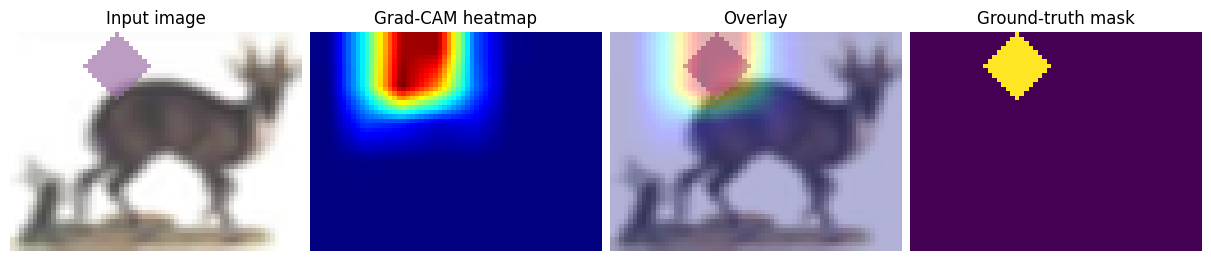

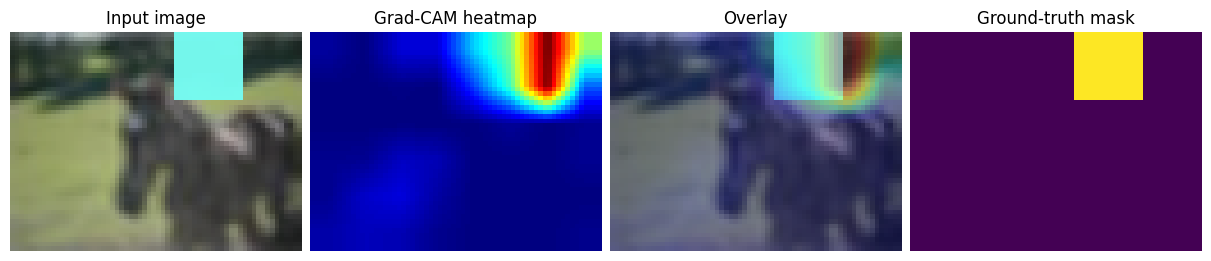

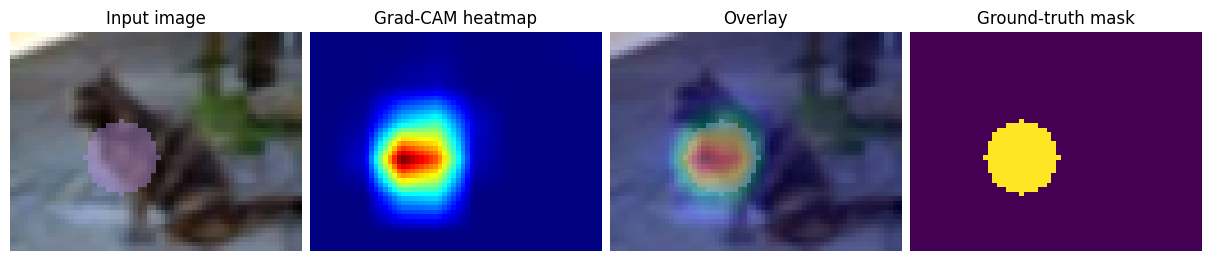

In [14]:
def example_gradcam():
    grad_cam = GradCAM(model=model, target_layers=target_layers)

    for test_idx in [3, 10, 42]:
        img, label, mask = test_dataset[test_idx]

        cam = grad_cam(img.unsqueeze(0).to(device), targets=[label])
        heatmap_img = heatmap_to_rgb_image(cam.squeeze(0), 0, 1)

        show_image_row(
            {
                "Input image": inverse_transform(img),
                "Grad-CAM heatmap": heatmap_img,
                "Overlay": PIL.Image.blend(inverse_transform(img), heatmap_img, alpha=0.3),
                "Ground-truth mask": mask,
            }
        )


example_gradcam()

# 2. Segment Anything Model



## Basic usage [do not modify]
The checkpoint takes 360 MB.

In [17]:
%pip install segment-anything
!wget -nc -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Note: you may need to restart the kernel to use updated packages.


In [18]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

sam_checkpoint_path = Path("./sam_vit_b_01ec64.pth")
assert sam_checkpoint_path.exists(), "SAM checkpoint not found."

# We'll use a single global SAM model to avoid reloading it to memory multiple times.
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path)
sam_model.to(device)
sam_predictor = SamPredictor(sam_model)

In [19]:
class BasicSamPipeline:
    def __call__(self, images: Tensor) -> Tensor:
        """
        Input: normalized images, shape (B, C=3, H, W).
        Output: masks tensor of shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        # The basic pipeline always uses a single center point for each image.
        point_coords = np.array([[(W // 2, H // 2)] for _ in range(B)])

        # The basic pipeline always uses a single foreground point, no background points.
        point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

        return self.segment(images, point_coords, point_labels)

    def segment(
        self, images: Tensor, point_coords: np.ndarray, point_labels: np.ndarray
    ) -> Tensor:
        """
        Args:
        - images: normalized images, shape (B, C=3, H, W).
        - point_coords: point coordinates within each image, shape (B, num_points, 2), format (x,y).
            Note the format is not (h,w)=(y,x), but (x,y)!
        - point_labels: point labels, shape (B, num_points), dtype int64.
            Label 1 is foreground (should be in mask), 0 is background (shouldn't be in mask).

        Returns: segmentation masks, shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        assert C == 3, f"Expected images.shape=(B, C=3, H, W), got: {images.shape}"
        num_points = point_coords.shape[1]
        assert point_coords.shape == (B, num_points, 2), f"Expected point_coords.shape=({B=}, num_points, 2), got: {point_coords.shape}"
        assert point_labels.shape == (B, num_points), f"Expected point_labels.shape=({B=}, num_points), got: {point_labels.shape}"

        results = list[Tensor]()
        for image, pt_coords, pt_labels in zip(images, point_coords, point_labels, strict=True):
            sam_predictor.set_image(np.array(inverse_transform(image)))
            masks, scores, _logits = sam_predictor.predict(
                point_coords=pt_coords, point_labels=pt_labels, multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            results.append(torch.tensor(best_mask, dtype=torch.bool))
        return torch.stack(results)

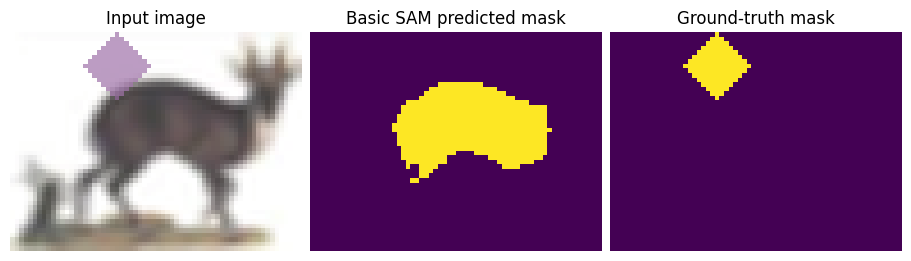

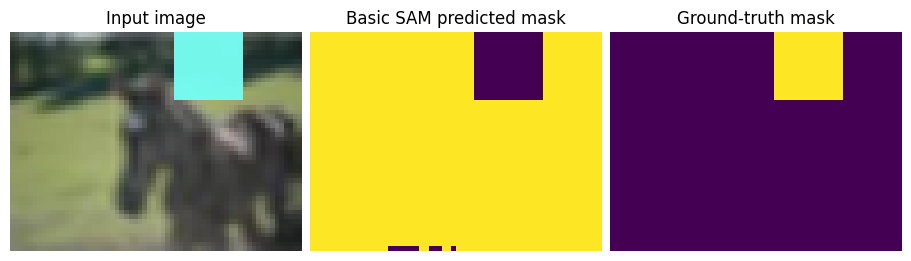

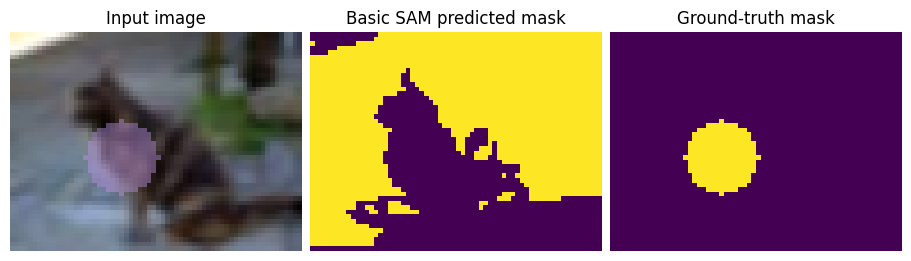

In [20]:
def example_sam():
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]

    basic_pipeline = BasicSamPipeline()

    results = basic_pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                "Basic SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )


example_sam()

## Pipeline implementation and evaluation (add your code)

In [21]:
sam_eval_loader = DataLoader(test_dataset, batch_size=5, num_workers=0, pin_memory=use_accel)

Add any necessary cells regarding pipeline and evaluation.

In [22]:
# --- Pipelines ---

class SamPipelineFGOnly(BasicSamPipeline):
    """One foreground point only: (x,y) = argmax of Grad-CAM."""
    def __init__(self, grad_cam: GradCAM):
        self.grad_cam = grad_cam
        self.last_point_coords: np.ndarray | None = None
        self.last_point_labels: np.ndarray | None = None

    def __call__(self, images: Tensor) -> Tensor:
        B, C, H, W = images.shape
        cams = self.grad_cam(images, targets=None)  # (B,H,W) numpy in [0,1]

        point_coords = np.zeros((B, 1, 2), dtype=np.float32)
        point_labels = np.ones((B, 1), dtype=np.int64)

        for b in range(B):
            y, x = np.unravel_index(np.argmax(cams[b]), (H, W))
            point_coords[b, 0] = (float(x), float(y))

        self.last_point_coords = point_coords
        self.last_point_labels = point_labels
        return self.segment(images, point_coords, point_labels)


class SamPipelineFGBG(BasicSamPipeline):
    """
    Foreground + background:
    - FG point = centroid of top-q Grad-CAM pixels (fallback: argmax)
    - BG point = corner with lowest Grad-CAM value
    """
    def __init__(self, grad_cam: GradCAM, fg_quantile: float = 0.90):
        self.grad_cam = grad_cam
        self.fg_quantile = fg_quantile
        self.last_point_coords: np.ndarray | None = None
        self.last_point_labels: np.ndarray | None = None

    def __call__(self, images: Tensor) -> Tensor:
        B, C, H, W = images.shape
        cams = self.grad_cam(images, targets=None)  # (B,H,W)

        point_coords = np.zeros((B, 2, 2), dtype=np.float32)  # 2 points: FG, BG
        point_labels = np.zeros((B, 2), dtype=np.int64)
        point_labels[:, 0] = 1  # first is foreground
        point_labels[:, 1] = 0  # second is background

        corners = np.array([[0, 0], [W - 1, 0], [0, H - 1], [W - 1, H - 1]], dtype=np.int64)

        for b in range(B):
            cam = cams[b]

            # FG: centroid of top quantile region
            thr = np.quantile(cam, self.fg_quantile)
            ys, xs = np.where(cam >= thr)
            if len(xs) == 0:
                y_fg, x_fg = np.unravel_index(np.argmax(cam), (H, W))
            else:
                x_fg = int(np.round(xs.mean()))
                y_fg = int(np.round(ys.mean()))
                x_fg = int(np.clip(x_fg, 0, W - 1))
                y_fg = int(np.clip(y_fg, 0, H - 1))

            point_coords[b, 0] = (float(x_fg), float(y_fg))

            # BG: corner with minimal activation
            corner_vals = [cam[y, x] for x, y in corners]
            bg_idx = int(np.argmin(corner_vals))
            x_bg, y_bg = corners[bg_idx]
            point_coords[b, 1] = (float(x_bg), float(y_bg))

        self.last_point_coords = point_coords
        self.last_point_labels = point_labels
        return self.segment(images, point_coords, point_labels)


In [23]:
def _fg_point_from_pipeline(pipeline: BasicSamPipeline, b: int) -> tuple[int, int]:
    # Uses saved points from the last pipeline call
    coords = getattr(pipeline, "last_point_coords", None)
    labels = getattr(pipeline, "last_point_labels", None)
    assert coords is not None and labels is not None, "Pipeline did not store last_point_coords/labels."

    fg_indices = np.where(labels[b] == 1)[0]
    assert len(fg_indices) > 0, "No foreground point found."
    fg_i = int(fg_indices[0])

    x = int(np.round(coords[b, fg_i, 0]))
    y = int(np.round(coords[b, fg_i, 1]))
    return x, y


def _mask_center_of_mass(mask: np.ndarray) -> tuple[float, float]:
    # mask: (H,W) bool
    ys, xs = np.nonzero(mask)
    if len(xs) == 0:
        # degenerate case
        H, W = mask.shape
        return (W / 2.0, H / 2.0)
    return (float(xs.mean()), float(ys.mean()))  # (cx, cy)


def _iou(pred: np.ndarray, gt: np.ndarray) -> float:
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return float(inter) / float(union + 1e-8)


def evaluate_sam_pipeline(pipeline: BasicSamPipeline, loader: DataLoader, device: torch.device) -> dict[str, float]:
    total_iou = 0.0
    total_hit = 0
    total_dist = 0.0
    n = 0

    for images, _labels, gt_masks in tqdm(loader, desc=type(pipeline).__name__ + " eval"):
        images = images.to(device)
        # gt_masks is usually a numpy array inside the dataset; DataLoader makes it a tensor of dtype=bool or uint8
        gt_masks_np = gt_masks.cpu().numpy().astype(bool)  # (B,H,W)

        pred_masks = pipeline(images).cpu().numpy().astype(bool)  # (B,H,W)

        B = pred_masks.shape[0]
        for b in range(B):
            gt = gt_masks_np[b]
            pred = pred_masks[b]

            # FG point metrics
            x, y = _fg_point_from_pipeline(pipeline, b)
            H, W = gt.shape
            x = int(np.clip(x, 0, W - 1))
            y = int(np.clip(y, 0, H - 1))

            hit = bool(gt[y, x])
            total_hit += int(hit)

            cx, cy = _mask_center_of_mass(gt)
            total_dist += float(np.sqrt((x - cx) ** 2 + (y - cy) ** 2))

            # Segmentation metric
            total_iou += _iou(pred, gt)

            n += 1

    return {
        "hit_rate": total_hit / n,
        "distance": total_dist / n,
        "mean_iou": total_iou / n,
    }


In [24]:
# Build Grad-CAM once (reuse the same layers chosen earlier)
grad_cam = GradCAM(model=model, target_layers=target_layers)

pipeline_fg = SamPipelineFGOnly(grad_cam)
pipeline_fgbg = SamPipelineFGBG(grad_cam, fg_quantile=0.90)

metrics_fg = evaluate_sam_pipeline(pipeline_fg, sam_eval_loader, device=device)
metrics_fgbg = evaluate_sam_pipeline(pipeline_fgbg, sam_eval_loader, device=device)

print("FG only:", metrics_fg)
print("FG+BG  :", metrics_fgbg)


SamPipelineFGBG eval: 100%|██████████| 100/100 [05:28<00:00,  3.28s/it]

FG only: {'hit_rate': 0.666, 'distance': 6.099616562981776, 'mean_iou': 0.7030191283972305}
FG+BG  : {'hit_rate': 0.806, 'distance': 4.637195191012052, 'mean_iou': 0.8205301902508568}
